# Проект: "Принятие решений в бизнесе. Анализ крупного интернет-магазина"

# Описание проекта  
Необходимо провести анализ крупного интернет-магазина и вместе с отделом маркетинга подготовить список гипотез для увеличения выручки. Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.   

**Описание данных**  

*Данные для первой части*  
Файл /datasets/hypothesis.csv.    
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

*Данные для второй части*  
Файл /datasets/orders.csv.    
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv.  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных.

**Изучим файлы и выполним предобработку данных**

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
import scipy.stats as stats

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы hypothesis, orders и visitors

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
orders = pd.read_csv('/datasets/orders.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)    
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Столбцы с датой и временем приведем к типу datetime64.

### Получим информацию о датафрейме hypothesis, в котором находятся гипотезы.

In [3]:
display(hypothesis)
display("Oсновная информация о датафрейме hypothesis")
display(hypothesis.info())
display("Числовое описание данных")
display(hypothesis.describe())
display("Количество пропусков")
display(hypothesis.isna().sum())
print("Количество явных дубликатов", hypothesis.duplicated().sum())
display("Hаличие неявных дубликатов")
display(hypothesis.value_counts())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


'Oсновная информация о датафрейме hypothesis'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

'Числовое описание данных'

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


'Количество пропусков'

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Количество явных дубликатов 0


'Hаличие неявных дубликатов'

Hypothesis                                                                                                    Reach  Impact  Confidence  Efforts
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  8      3       7           3          1
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей            3      10      8           6          1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                      3      2       2           3          1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок              10     7       8           5          1
Запустить акцию, дающую скидку на товар в день рождения                                                       1      9       9           5          1
Запустить собственную службу доставки, что сократит срок доставки заказов                                

В названиях столбцов есть расхождения с хорошим стилем. На этапе предобработки данных их необходимо привести к нижнему регистру.

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

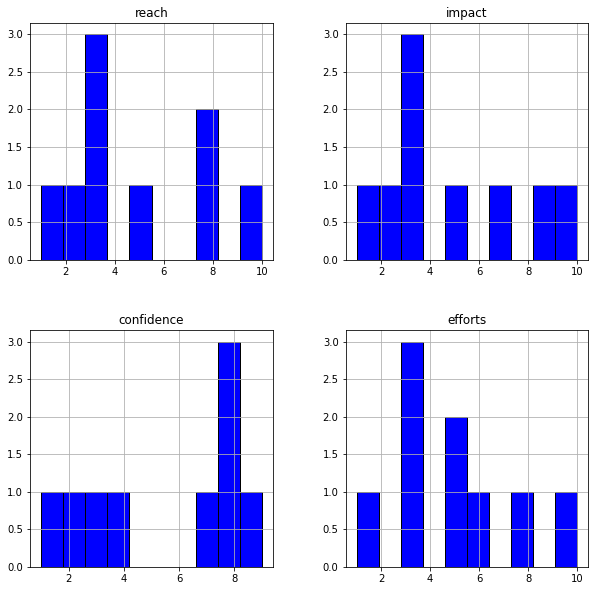

In [5]:
hypothesis.hist(figsize=(10, 10), color='b', ec='black') 
plt.show()

Данные корректны, типы данных верны, дубликатов и пропусков нет. 

### Получим информацию о датафрейме orders, в котором находится информация о заказах.

In [6]:
display(orders)
display("Oсновная информация о датафрейме orders")
display(orders.info())
display("Числовое описание данных")
display(orders.describe())
display("Количество пропусков")
display(orders.isna().sum())
print("Количество явных дубликатов", orders.duplicated().sum())
display("Hаличие неявных дубликатов")
display(orders.value_counts())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


'Oсновная информация о датафрейме orders'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

'Числовое описание данных'

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


'Количество пропусков'

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Количество явных дубликатов 0


'Hаличие неявных дубликатов'

transactionId  visitorId   date        revenue  group
1062393        2661240577  2019-08-05  6420     A        1
2883105032     3086835579  2019-08-23  2646     A        1
2875229767     1627549308  2019-08-05  650      B        1
2872509092     983496389   2019-08-02  165      A        1
2866469834     3917749921  2019-08-29  3950     B        1
                                                        ..
1476831880     1422476412  2019-08-14  6180     A        1
1476390797     2044161277  2019-08-31  1450     B        1
1473132782     4069496402  2019-08-12  640      B        1
1472783002     1617417821  2019-08-26  1690     A        1
4293855558     8300375     2019-08-07  1790     A        1
Length: 1197, dtype: int64

В названиях столбцов есть расхождения с хорошим стилем. На этапе предобработки данных их необходимо привести к нижнему регистру, добавить нижнее подчеркивание.

In [7]:
orders.columns = orders.columns.str.replace('transactionId', 'transaction_id') 
orders.columns = orders.columns.str.replace('visitorId', 'visitor_id') 

Типы данных во всех колонках соответствуют сохранённым в них значениям. 

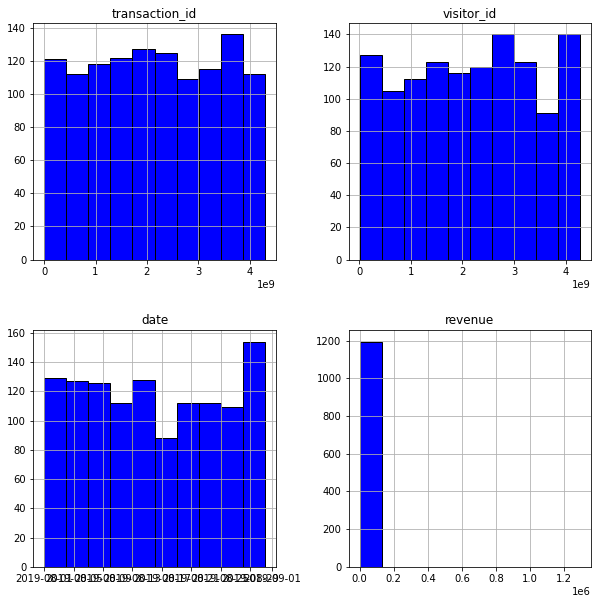

In [8]:
orders.hist(figsize=(10, 10), color='b', ec='black') 
plt.show()

Данные корректны, типы данных верны, дубликатов и пропусков нет. Возможны аномалии в значениях revenue. 

### Получим информацию о датафрейме visitors, в котором находится информация о пользователях.

In [9]:
display(visitors)
display("Oсновная информация о датафрейме visitors")
display(visitors.info())
display("Числовое описание данных")
display(visitors.describe())
display("Количество пропусков")
display(visitors.isna().sum())
print("Количество явных дубликатов", visitors.duplicated().sum())
display("Hаличие неявных дубликатов")
display(visitors.value_counts())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


'Oсновная информация о датафрейме visitors'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

'Числовое описание данных'

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


'Количество пропусков'

date        0
group       0
visitors    0
dtype: int64

Количество явных дубликатов 0


'Hаличие неявных дубликатов'

date        group  visitors
2019-08-01  A      719         1
2019-08-24  A      395         1
2019-08-17  B      421         1
2019-08-18  A      668         1
            B      737         1
                              ..
2019-08-13  B      769         1
2019-08-14  A      735         1
            B      746         1
2019-08-15  A      628         1
2019-08-31  B      718         1
Length: 62, dtype: int64

Типы данных во всех колонках соответствуют сохранённым в них значениям. 

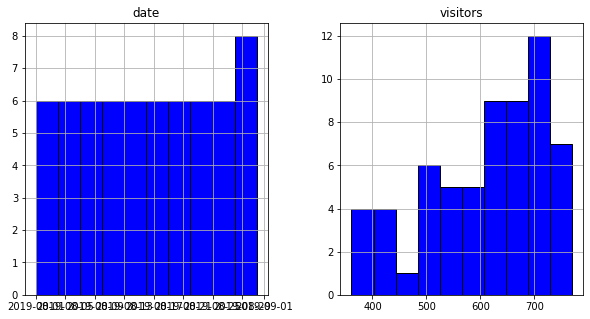

In [10]:
visitors.hist(figsize=(10, 5), color='b', ec='black') 
plt.show()

Данные корректны, типы данных верны, дубликатов и пропусков нет. 

**Вывод**  
В нашем распоряжении три датасета:  
 
Файл /datasets/hypothesis.csv.    
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

  
Файл /datasets/orders.csv.    
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv.  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

В названиях столбцов есть расхождения с хорошим стилем. Эти названия были приведены к нижнему регистру, а также заменины пробелы на нижнее подчеркивание.  
Типы данных во всех колонках соответствуют сохранённым в них значениям. Столбцы с датой и временем приведены к типу datetime64.  
Дубликаты и пропуски отсуствуют. Возможны аномалии в значениях revenue.

## Часть 1. Приоритизация гипотез.  
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.  

*Задача:*  
1. Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.  
2. Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.  
3. Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. 

In [11]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. 

In [12]:
hypothesis['RICE'] = ((hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']) / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


### Как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

ТОП-3 гипотезы по оценке ICE под номерами 8, 0, 7.  
ТОП-3 гипотезы по оценке RICE под номерами 7, 2, 0. В фреймворке RICE учитывается параметр reach, отвечающий за охват пользователей по 10-балльной шкале. Найдем наибольшее значение этого параметра.

In [13]:
display(hypothesis['reach'].sort_values(ascending=False))

7    10
2     8
3     8
6     5
0     3
4     3
5     3
1     2
8     1
Name: reach, dtype: int64

**Вывод**  
Гипотеза под номером 8 имеет минимальный охват. Несмотря на то, что гипотеза под номером 8 лидирует по результатам оценки ICE, тестировать её нецелесообразно.  
Гипотеза под номером 0 также имеет низкий охват. Её также тестировать нецелесообразно.  
Гипотезу под номером 7 однозначно рекомендую отправить на тестирование. По оценке ICE она занимает 3 место, по оценке RICE 1 место и имеет максимальный охват.  
Гипотеза под номером 2 имеет хороший охват, занимает по оценке RICE 2 место, по оценке ICE -  5 место. Её также можно предложить отправить на тестирование. 

## Часть 2. Анализ A/B-теста
Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.  

*Задача*  
Необходимо проанализировать A/B-тест:  
1. Построить график кумулятивной выручки по группам. Сделать выводы и предположения.  
2. Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.  
3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.  
4. Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения.  
5. Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения.  
6. Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.  
7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.  
8. Построить точечный график стоимостей заказов. Сделать выводы и предположения.  
9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.  
10. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения.  
11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.  
12. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения.  
13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.  
14. Принять решение по результатам теста и объясните его. Варианты решений:  
  1. Остановить тест, зафиксировать победу одной из групп.  
  2. Остановить тест, зафиксировать отсутствие различий между группами.  
  3. Продолжить тест.

Найдем количество пользователей в указанную дату и количество заказов в каждой группе.

In [14]:
# Количество пользователей в указанную дату
visitors_new = (
    visitors.groupby('group', as_index=False)
    .agg({'visitors': 'sum'})
)

print(visitors_new)

  group  visitors
0     A     18736
1     B     18916


In [15]:
# разница между количеством пользователей в группе А и в группе В
abs(visitors.query('group == "A"')['visitors'].sum() - visitors.query('group == "B"')['visitors'].sum())

180

In [16]:
# Количество заказов
orders_new = (
    orders.groupby('group', as_index=False)
    .agg({'visitor_id': 'count'})
)

print(orders_new)

  group  visitor_id
0     A         557
1     B         640


In [17]:
# отношение числа заказов к количеству пользователей в каждой группе
orders_new['ordersToVisitorsRatio'] = (
    orders_new['visitor_id'] / visitors_new['visitors']
).map(lambda x: "{0:.3f}".format(x))
print(orders_new)

  group  visitor_id ordersToVisitorsRatio
0     A         557                 0.030
1     B         640                 0.034


In [18]:
# количество пользователей, которые попали в обе группы 
orders.loc[orders['visitor_id'].isin(orders[orders['group'] == 'A']['visitor_id']) & 
           orders['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id']), 'visitor_id'].nunique()

58

58 пользователей попало в обе группы. Удалим их.

In [19]:
# создадим таблицу, из которой возьмем дубли group
doubles_orders = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'transaction_id' : 'count'}).reset_index()

In [20]:
# исключим пользователей, которые попали в обе группы 
doubles_list = list(doubles_orders[doubles_orders.group > 1]['visitor_id'])
orders = orders.query('visitor_id not in @doubles_list')

In [21]:
print ('Количество заказов в группе А:', orders.query('group == "A"').shape[0])
print ('Количество заказов в группе B:', orders.query('group == "B"').shape[0])

Количество заказов в группе А: 468
Количество заказов в группе B: 548


### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

Oбъединяем кумулятивные данные в одной таблице

In [22]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transaction_id' : 'nunique', 
                                          'visitor_id' : 'nunique', 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

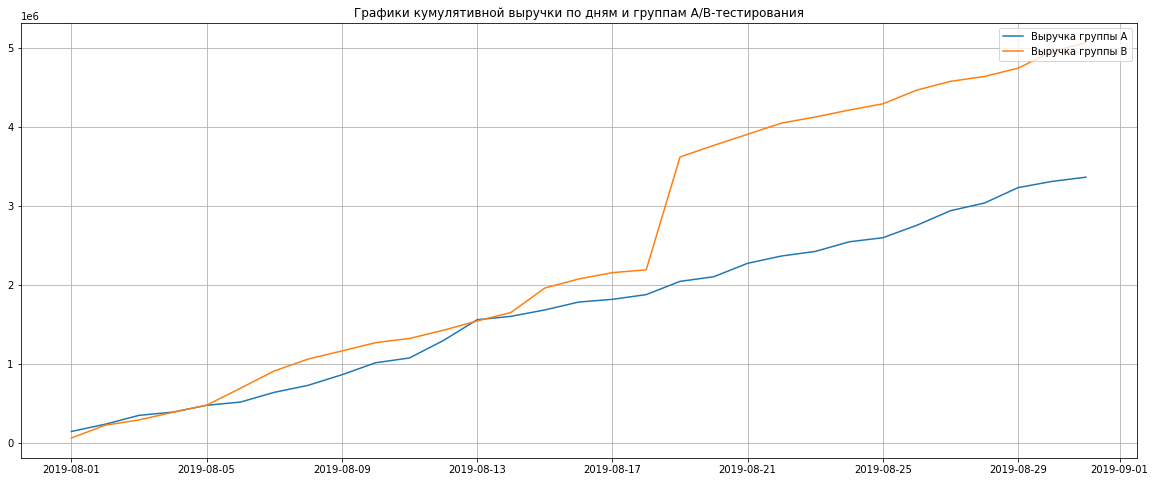

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 8))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Выручка группы A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Выручка группы B')

plt.grid()
plt.title('Графики кумулятивной выручки по дням и группам A/B-тестирования')
plt.legend(loc='upper right')
plt.show()

Выручка почти равномерно увеличивается и стала равной 13.08.2019г. Затем выручка группы В стала значительно больше. Однако график выручки группы В в короткий период резко вырос. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Рассмотрим период с 17.08.2019 по 21.08.2019 для графика В. 

In [24]:
orders.query('"2019-08-17" < date < "2019-08-21"').sort_values(by='revenue', ascending=False).head()

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
751,348143148,689129267,2019-08-20,37150,B
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A


In [25]:
print('Стоимость средней покупки в период с 17.08.2019 по 21.08.2019 составляет: ', orders
      .query('"2019-08-17" < date < "2019-08-21"')['revenue'].median().round(2))

Стоимость средней покупки в период с 17.08.2019 по 21.08.2019 составляет:  2578.0


19.08.2019г. была одна крупная покупка на сумму 1294500 руб., что гораздо выше средней покупки в период с 17.08.2019 по 21.08.2019. Проверим на боксплоте является ли эта покупка выбросом. 

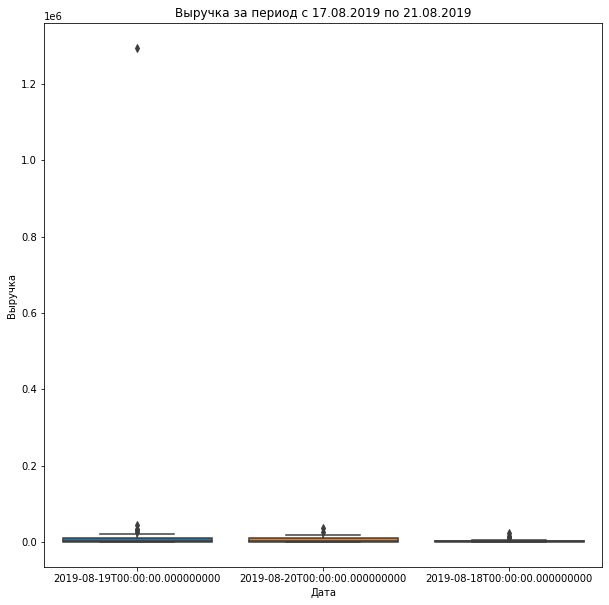

In [26]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='date', y='revenue', data=orders.query('"2019-08-17" < date < "2019-08-21"')
            .sort_values(by='revenue', ascending=False))
plt.title('Выручка за период с 17.08.2019 по 21.08.2019')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Данное значение предположительно является выбросом. 

### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

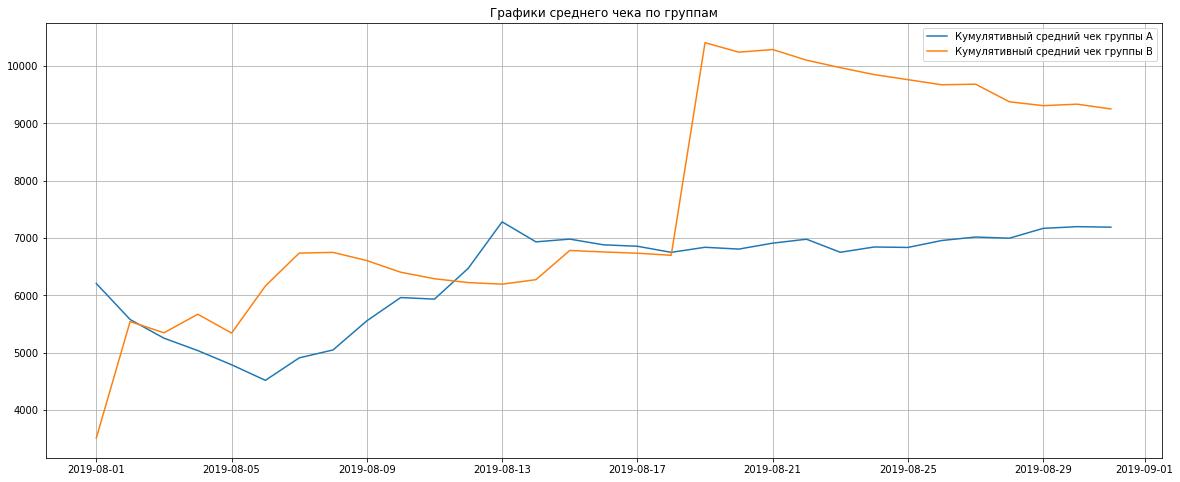

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Кумулятивный средний чек группы A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Кумулятивный средний чек группы B')
plt.title('Графики среднего чека по группам')
plt.grid()
plt.legend(loc='upper right')
plt.show()

Кумулятивный средний чек группы B практически всегда выше, чем у группы А. Исключением являются два периода: с 01.08.2019 по 03.08.2019 и с 11.08.2019 по 15.08.2019. Также на графике группы В заметен вброс от 19.08.2019 года. 

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline():

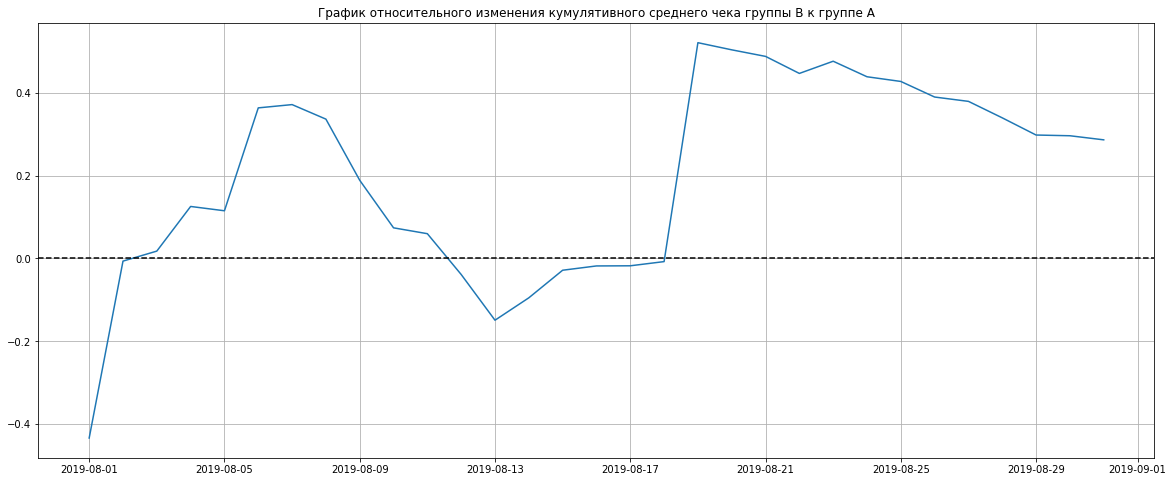

In [28]:
plt.figure(figsize=(20, 8))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.grid()
plt.show()

По графику можно отметить периоды роста кумулятивного среднего чека группы B к группе A: с 02.08.2019 по 12.08.2019 и с 15.08.2019 по 31.08.2019. А также периоды периоды снижения: с 01.08.2019 по 02.08.2019 и с 12.08.2019 по 15.08.2019. 

### Построим график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.

Аналогично проанализируем график кумулятивного среднего количества заказов на посетителя по группам. 

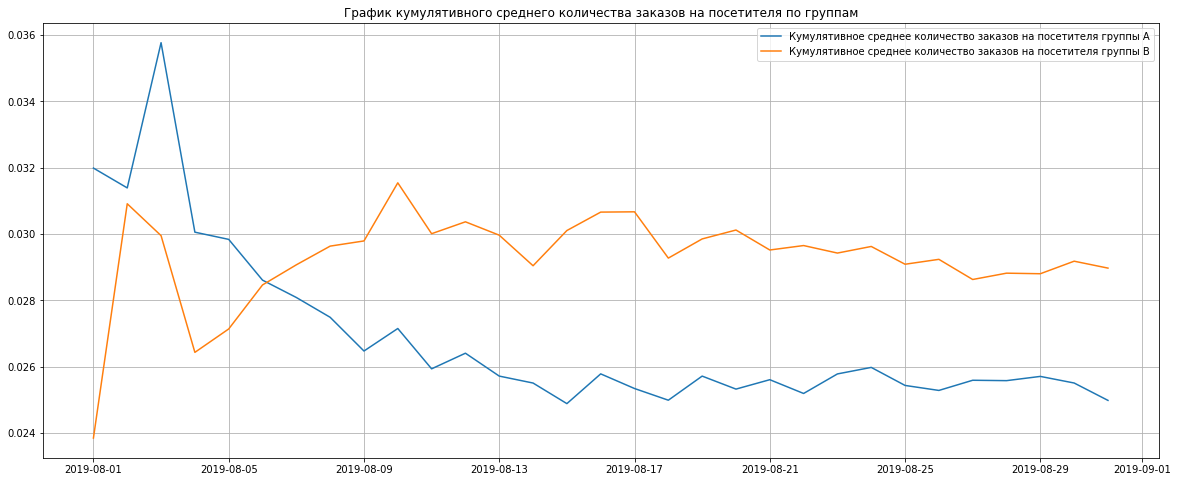

In [29]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(20, 8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Кумулятивное среднее количество заказов на посетителя группы A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Кумулятивное среднее количество заказов на посетителя группы B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.grid()
plt.show()

В период с 01.08.2019 по 06.08.2019 кумулятивное среднее количество заказов на посетителя группы A выше группы В. Затем с 06.08.2019 по 31.08.2019 наоборот кумулятивное среднее количество заказов на посетителя группы В стало значительно выше группы А. Графики в этот период практически симметричны. 

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения. 

Построим график изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:

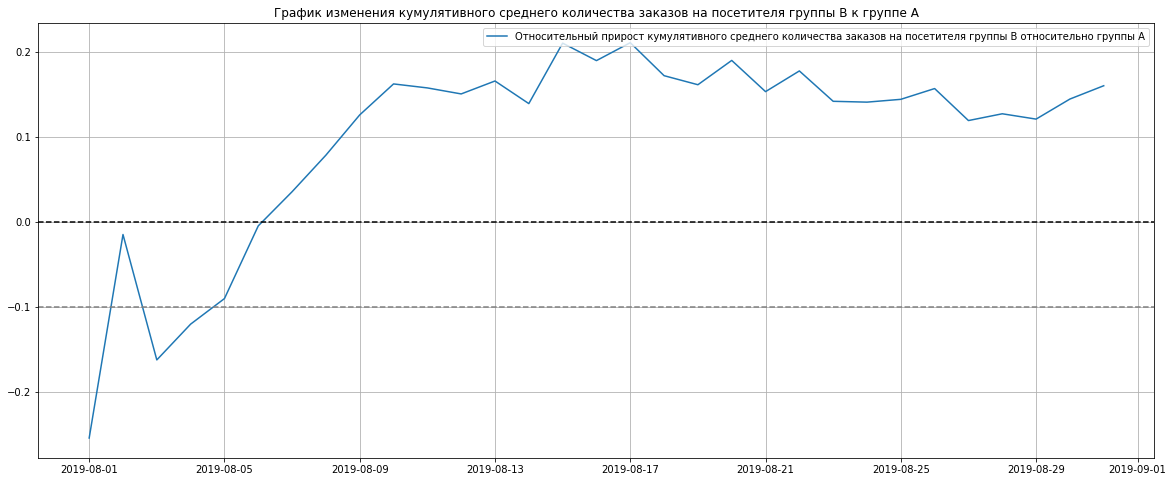

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20, 8))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.legend(loc='upper right')
plt.title('График изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.grid()
plt.show()

Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A первоначально составлял около 5-10%. После 06.08.2019 график стал расти и принял свой максимум 15.08.2019, что составило около 21%. Затем происходит постепенно снижение и прирост на период 06.08.2019 по 31.08.2019 составил около 10-15%.

### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [31]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [32]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['user_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

        user_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


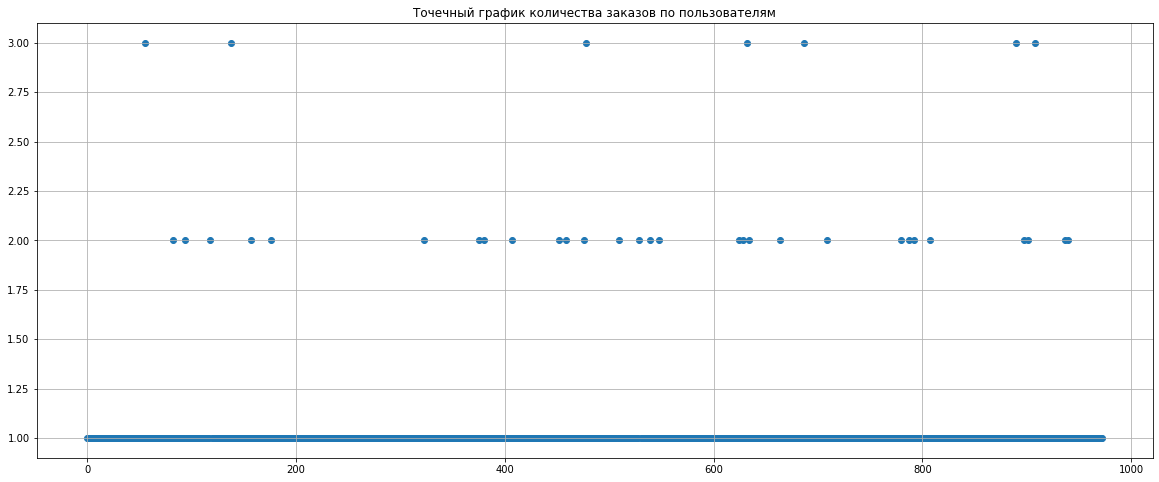

In [33]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(20, 8))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.grid()
plt.show()

В основном пользователи совершали по 1 заказу. Небольшое количество пользователей совершало 2 заказа, еще реже 3 заказа. Большее количество заказов настолько редкое, что их можно считать аномалиями. 

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [34]:
print('95-й и 99-й перцентили количества заказов на пользователя составляют: ', 
      np.percentile(ordersByUsers['orders'], [95, 99])) 

95-й и 99-й перцентили количества заказов на пользователя составляют:  [1. 2.]


Лишь 1% пользователей делает 4 заказа. От 4 заказов и выше будем считать аномалией. 

### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

19.08.2019г. была одна крупная покупка на сумму 1294500 руб., являющаяся выбросом. Построим точечный график без нее.

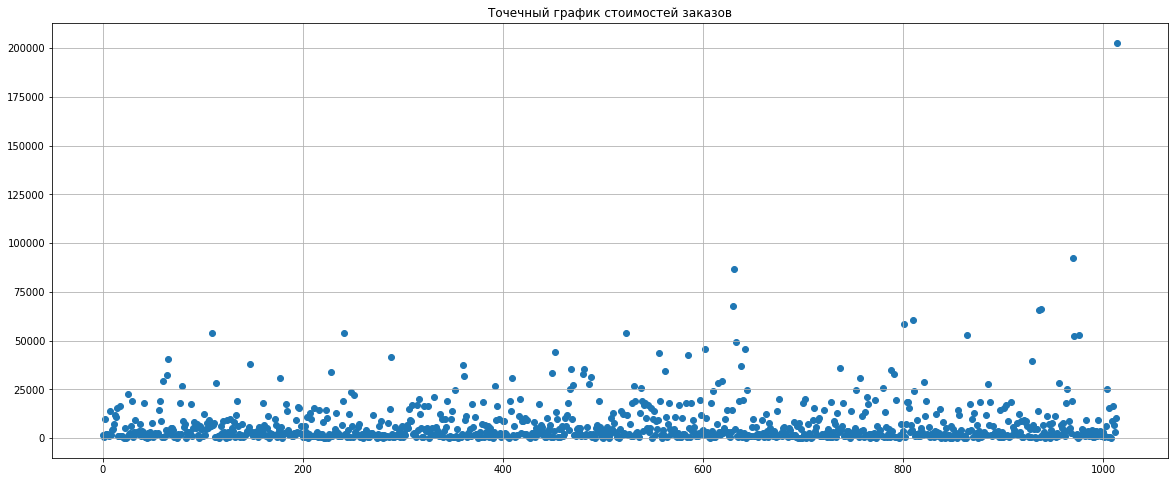

In [35]:
orders_1 = orders[orders['revenue'] != 1294500]['revenue']
x_1_values = pd.Series(range(0,len(orders_1)))
plt.figure(figsize=(20, 8))
plt.scatter(x_1_values, orders_1)
plt.title('Точечный график стоимостей заказов')
plt.grid()
plt.show()

На графике есть один выброс на 200000 руб. Большая часть заказов не превышает 25000 руб. Для нахождения более точной границы рассчитаем процентили.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [36]:
print('95-й и 99-й перцентили стоимости заказов составляют: ', 
      np.percentile(orders['revenue'], [95, 99])) 

95-й и 99-й перцентили стоимости заказов составляют:  [26785. 53904.]


Лишь 1% заказов больше 58233.2 руб. Примем их за аномалии.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.  

Примем за нулевую гипотезу Н0 утверждение: "Статистически значимых различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет."  
Альтернативная гипотеза Н1: "Статистически значимые различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть."  
Примем пороговое значение alpha = 0.05

Соберем все необходимые данные в одну таблицу.

In [37]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Напомним названия столбцов данных:  
date — дата;  
ordersPerDateA — количество заказов в выбранную дату в группе A;  
revenuePerDateA — суммарная выручка в выбранную дату в группе A;  
ordersPerDateB — количество заказов в выбранную дату в группе B;  
revenuePerDateB — суммарная выручка в выбранную дату в группе B;  
ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;  
revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;  
ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;  
revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;  
visitorsPerDateA — количество пользователей в выбранную дату в группе A;  
visitorsPerDateB — количество пользователей в выбранную дату в группе B;  
visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;  
visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['user_id', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [38]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.  
Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.  
Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.

In [39]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Oтносительный прирост среднего числа заказов группы B = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.011
Oтносительный прирост среднего числа заказов группы B = 0.160


p-value = 0.011 при пороговом значении alpha = 0.05. P-value меньше alpha - это значит, нулевую гипотезу: "Статистически значимых различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет." - отвергаем. Относительный выигрыш группы B равен 16%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами.  
Нулевая гипотеза: "Pазличий в среднем чеке между группами по «сырым» данным нет."  
    Альтернативная гипотеза: "Pазличия в среднем чеке между группами по «сырым» данным есть."  
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.   
А ещё найдём относительные различия в среднем чеке между группами:

In [40]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Oтносительный прирост среднего чека заказов группы B = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.829
Oтносительный прирост среднего чека заказов группы B = 0.287


Наблюдаемое различие в 28,7% не является статистически значимым, p-value = 0.829 при пороговом значении alpha = 0.05., нулевую гипотезу: "Pазличий в среднем чеке между группами по «сырым» данным нет." - не отвергаем.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

По результатам предыдущих ислледований мы выяснили, что лишь 1% пользователей делает 4 заказа. А также лишь 1% заказов больше 58233.2 руб. Примем их за аномалии. Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [41]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Всего аномальных пользователей - ', abnormalUsers.shape[0])

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
Всего аномальных пользователей -  16


Всего 16 аномальных пользователей.  
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [42]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам.  
Примем за нулевую гипотезу Н0 утверждение: "Статистически значимых различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нет."  
Альтернативная гипотеза Н1: "Статистически значимые различия в среднем количестве заказов на посетителя между группами по «очищенным» данным есть."  
Примем пороговое значение alpha = 0.05

In [43]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Oтносительный прирост среднего числа заказов группы B = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.007
Oтносительный прирост среднего числа заказов группы B = 0.189


p-value = 0.007 при пороговом значении alpha = 0.05. P-value меньше alpha - это значит, нулевую гипотезу: "Статистически значимых различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нет." - отвергаем. Относительный выигрыш группы B равен 18.9%. Результаты схожи с результами "сырых" данных.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

Нулевая гипотеза: "Pазличий в среднем чеке между группами по «очищенным» данным нет."  
    Альтернативная гипотеза: "Pазличия в среднем чеке между группами по «очищенным» данным есть."  
    Пороговое значение alpha = 0.05

In [44]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Oтносительный прирост среднего числа заказов группы B = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.788
Oтносительный прирост среднего числа заказов группы B = -0.032


Наблюдаемое различие в 3,2% не является статистически значимым, p-value = 0.788 при пороговом значении alpha = 0.05., нулевую гипотезу: "Pазличий в среднем чеке между группами по «очищенным» данным нет." - не отвергаем.

### Примем решение по результатам теста и объясним его. Варианты решений:  
1. Остановить тест, зафиксировать победу одной из групп.  
2. Остановить тест, зафиксировать отсутствие различий между группами.  
3. Продолжить тест.

**По результатам теста можно принять решение об остановке теста и зафиксировать победу группы В.**  
**Результаты теста:**  
1. При подсчете статистической значимости различий в среднем количестве заказов на посетителя между группами относительный выигрыш группы В над группой А оставил 16% по «сырым» и 18.9% по "очищенным" данным.  
2. При подсчете статистической значимости различий в среднем чеке между группами относительный выигрыш группы В над группой А оставил 28.7% по «сырым». Причина в аномальных заказах. По "очищенным" данным относительный проигрыш группы В над группой А оставил 3.2%, что незначительно.  
3. По результатам А/В теста были отвергнуты гипотезы: "Статистически значимых различий в среднем количестве заказов на посетителя между группами нет." Как по "сырым", так и по "ощищенным" данным. По количеству заказов лидирует группа В.  
4. По результатам А/В теста не были отвергнуты гипотезы: "Pазличий в среднем чеке между группами нет." Как по "сырым", так и по "ощищенным" данным. Различий в средних чеках группы А и группы В нет. 